In [1]:
# import necessary packages
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from itertools import product
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

In [2]:
# initialize spark
spark = SparkSession \
    .builder \
    .appName("municipality") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/21 03:05:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read data file
df=spark.read.option('header',True).csv("Sample_Traffic.csv")
# show top 5 rows
df.show(5)
# select needed columns
new_df=df.select([df.columns[i] for i in [0,2,6]])
# show top 5 selected rows
new_df.show(5)
# convert new_df to rdd format
ds=new_df.rdd

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows

+-----------+---------------+-------------------+
|DEVICE

### preproccesing

In [4]:
pass_time=ds.map(lambda x: ((x[0],x[1]),[datetime.strptime(x[2],'%Y-%m-%d %H:%M:%S')])) \
                    .reduceByKey(lambda x,y: x+y)
def sorting(x):
    time_list=x[1]
    time_list.sort()
    time_list.reverse()
    return (x[0],time_list)
pass_time_sort=pass_time.map(sorting)
def remove_outlier_data(x):
    time_list=x[1]
    new_time_list=[]
    for i in range(len(time_list)):
        if (time_list[i]-time_list[(i+1)%len(time_list)]).total_seconds()>=60:
            new_time_list.append(datetime.strftime(time_list[i],'%Y-%m-%d'))
    if len(time_list)==1:
        new_time_list=[datetime.strftime(time_list[0],'%Y-%m-%d')]
    return (x[0],new_time_list)
clear_pass_time=pass_time_sort.map(remove_outlier_data)
# find the (device_code,palte) with the most probable error
error_device=pass_time_sort.sortBy(lambda x: len(x[1]),ascending=False).take(1)[0]
print(f'the most number of passes for a car from a traffic light is {len(error_device[1])} before removing outlier datas')
print(f'the most number of passes for a car from a traffic light is {len(remove_outlier_data(error_device)[1])} after cleaning')
pass_device_code=clear_pass_time.flatMap(lambda x: product((x[0],),x[1])) \
                                    .map(lambda x: ((x[0][1],x[1]),[x[0][0]])) \
                                    .reduceByKey(lambda x,y: x+y) \
                                    .filter(lambda x: len(x[1])<=400)
pass_device_code.take(1)[0]

the most number of passes for a car from a traffic light is 2932 before removing outlier datas
the most number of passes for a car from a traffic light is 411 after cleaning


(('8687397', '2021-06-01'), ['202901', '22010051', '900240', '22010052'])

### cosine similarity

In [5]:
def build_vector(x, y):
    counter1 = Counter(x[1])
    counter2= Counter(y[1])
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2
def cosine_similarity(x,y):
    vec1,vec2=build_vector(x,y)
    cos_distance=np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    theta=math.acos(cos_distance)
    similarity=1-theta/math.pi
    return similarity
# make an assumptive path, choose randomly a path with the size of 10 from all pathes
assumptive_path=pass_device_code.filter(lambda x: len(x[1])==15).take(1)[0]
top_path_similarity=pass_device_code.map(lambda x: (x[0],(x[1],cosine_similarity(x,assumptive_path)))) \
                                    .sortBy(lambda x: x[1][1],ascending=False).take(5)
print(f'the assumptive path is {assumptive_path[1]}')
print('-'*55)
for path in top_path_similarity:
    print(f'the path is {path[1][0]} and the plate of car is {path[0][0]}')
    print(path[1][1])
    print('-'*55)

the assumptive path is (('9203915', '2021-06-01'), ['202901', '100700804', '100700834', '900265', '631765', '209103', '100700864', '900203', '175', '211301', '900191', '900191', '203902', '203902', '900242'])
-------------------------------------------------------
the path is ['202901', '100700804', '100700834', '900265', '631765', '209103', '100700864', '900203', '175', '211301', '900191', '900191', '203902', '203902', '900242'] and the plate of car is 9203915
0.9999999932921207
-------------------------------------------------------
the path is ['209103', '22009971', '900101', '900265', '100700834', '203902', '203902', '100700804', '175', '145', '211301', '900191', '900191', '22009972'] and the plate of car is 37043180
0.7733519637903687
-------------------------------------------------------
the path is ['202901', '202901', '202901', '202901', '202901', '202901', '203001', '900215', '203902', '203902', '203902', '203902', '203902', '203902', '203902', '22009923', '900265', '205201',

### LSH

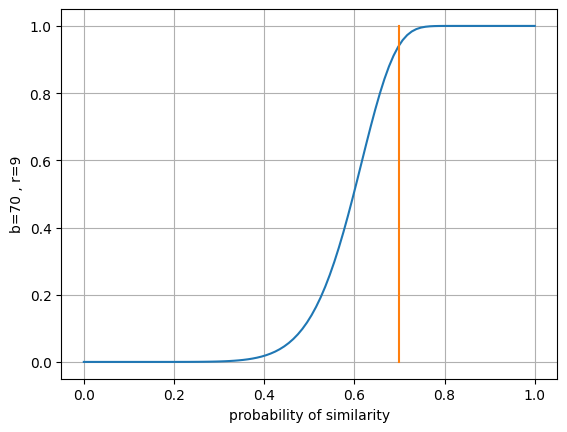

In [6]:
def build_dict(x):
    return dict(Counter(x[1]))
def hashing(x,v):
    dict_x=build_dict(x)
    effective_v=np.array([v[key] for key in dict_x])
    effective_v=effective_v.reshape(-1,effective_v.shape[0])
    vec=effective_v@np.array(list(dict_x.values()))
    return vec>=0
def hash_document(x,v_matrix,all_device_code):
    v=dict(zip(all_device_code,v_matrix))
    ls=hashing(x,v)
    return (x[0],(x[1],ls))
# finding the total possible device codes
all_device_code=pass_device_code.map(lambda x: set(x[1])).reduce(lambda x,y: x.union(y))
n=len(all_device_code)
# for using AND | OR concepts we assign b=50 and r=8 where br=m
# note: at first we use AND then OR operations
number_bands=70
number_rows=9
t=np.linspace(0,1,100)
s=1-(1-t**number_rows)**number_bands
figure,ax=plt.subplots()
ax.plot(t,s)
ax.plot([0.7,0.7],[0,1])
ax.set_xlabel('probability of similarity')
ax.set_ylabel(f'b={number_bands} , r={number_rows}')
ax.grid()
# find m random v vector
m=number_bands*number_rows
elements=[-1,1]
v_matrix=np.random.choice(elements,(n,m))
#computing signature matrix
signature_matrix=pass_device_code.map(lambda x: hash_document(x,v_matrix,all_device_code))

In [7]:
# for hashing we use p=2^61-1 that is prime number and it is as large as needed 
# if we use p prime number, the probability that 2 items map to the same bucket is at least p1 where is
# in the order of 1e-5
# note: for more information, refer to the HW report
# the below code shows the probability
N=len(pass_device_code.collect())
bucket=2**67-1
p=1
for i in range(N):
    p*=(bucket-i)/bucket
p1=1-p
print(f'the probability of two items goes to the same bucket is about {p1*100}%')

23/01/21 03:06:58 WARN TransportClientFactory: DNS resolution succeed for hp-omen/172.27.171.82:35605 took 5944 ms


the probability of two items map goes to the same bucket is about 1.0164830310799289e-06%


In [8]:
# hasing all bands
def hash_band(vector,bucket):
    return hash(tuple(vector))%bucket
def choose_bucket(x,bucket,number_bands,number_rows):
    signature=x[1][1]
    bucket_ls=[hash_band(signature[b*number_rows:(b+1)*number_rows],bucket) for b in range(number_bands)]
    return (x[0],(x[1][0],bucket_ls))
similar_items=signature_matrix.map(lambda x: choose_bucket(x,bucket,number_bands,number_rows))

In [10]:
# hashing assumptive path
def hash_assumptive_path(assumptive_path,v_matrix,all_device_code,bucket,number_bands,number_rows):
    signature_vec=hash_document(assumptive_path,v_matrix,all_device_code)
    similarity=choose_bucket(signature_vec,bucket,number_bands,number_rows)
    return np.array(similarity[1][1])
# finding all similar items for this assumptive path
similarity=hash_assumptive_path(assumptive_path,v_matrix,all_device_code,bucket,number_bands,number_rows)
total_similar_items=similar_items.filter(lambda x: any(np.array(x[1][1])==similarity)) \
                                    .map(lambda x: (x[0],x[1][0])) \
                                    .map(lambda x: (x[0],(x[1],cosine_similarity(x,assumptive_path)))) \
                                    .sortBy(lambda x: x[1][1],ascending=False).take(5)
print(f'the assumptive path is {assumptive_path[1]}')
print('-'*70)
for path in total_similar_items:
    print(f'the path is {path[1][0]} and the plate of car is {path[0][0]}')
    print(path[1][1])
    print('-'*65)

the assumptive path is ['202901', '100700804', '100700834', '900265', '631765', '209103', '100700864', '900203', '175', '211301', '900191', '900191', '203902', '203902', '900242']
----------------------------------------------------------------------
the path is ['202901', '100700932', '900118', '900216', '100700864', '100700864', '100700864', '107301', '900239', '175', '175', '175', '900191', '900191', '900191', '900191', '900191', '900191', '203902', '203902', '203902', '900242'] and the plate of car is 8551233
0.7526327582266752
-----------------------------------------------------------------
the path is ['203902', '203902', '203902', '203902', '203902', '203902', '203902', '113', '202901', '175', '175', '175', '900191', '900191', '900191', '900191', '900191', '900191', '900191', '900191', '900191'] and the plate of car is 9040909
0.7448305655154388
-----------------------------------------------------------------
the path is ['175', '232', '900191', '900191', '900191', '900191', '

In [59]:
a=similar_items.filter(lambda x: (x[0],x[1][0])==assumptive_path).take(1)[0]
b=(a[0],a[1][0])
c=np.array(a[1][1])
hash_assumptive_path(b,v_matrix,all_device_code,bucket,number_bands,number_rows)==c

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [55]:
hash_assumptive_path(assumptive_path,v_matrix,all_device_code,bucket,number_bands,number_rows)

array([1870161674818193243, 146462527349933266806, 143094686777537694992,
       3306437917098454531, 5103040370781907104, 4090844574982032082,
       145855256836114037016, 6141707726213528455, 1198946419452415239,
       138441610378918005702, 4845276646923836960, 146928350789519057906,
       146335841162388582473, 6079446267149598077, 3755235225256482217,
       3631568700088505955, 147407542914314901871, 142702065349833066864,
       145510131026662949603, 144902012564742081589,
       147174687317581569938, 143745973462996406719, 1670269163844383520,
       145248814237538011329, 647068424473703308, 3976729284455197465,
       142066473172110394284, 8764019581339796646, 139022670676703346615,
       2259286633844117952, 140547059846266357652, 923979151088165514,
       146388204128605272001, 140372616379453414693,
       145510131026662949603, 2047216644927834475, 143582325978681237124,
       901447417977520563, 8548798039696304158, 3002692529735983138,
       231600365729688396